In [43]:
#imports
import pandas as pd
import numpy as np
import random
import re
import recordlinkage
import time
import matplotlib.pyplot as plt

# ML imports 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

# prevent depreciation warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

## repeated printouts
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


## Read in and assign a unique identifier via the index

In [20]:
# read in our PreMatrix csv from step A
preMatrix = pd.read_csv('PreMatrix.csv').drop(columns=['Unnamed: 0'])
preMatrix = preMatrix.reset_index().copy()
preMatrix = preMatrix.rename(columns={"index": 'unique_id'})
## convert the dates to datetime objects

preMatrix.columns
preMatrix.info()
# y = preMatrix.loc[:, ['is_violator']].copy()
y = list(preMatrix.is_violator)

Index(['unique_id', 'CASE_NO', 'DECISION_DATE', 'VISA_CLASS',
       'CASE_RECEIVED_DATE', 'CASE_STATUS', 'REQUESTED_START_DATE_OF_NEED',
       'REQUESTED_END_DATE_OF_NEED', 'PRIMARY_SUB', 'EMPLOYER_NAME',
       'TRADE_NAME_DBA', 'EMPLOYER_ADDRESS1', 'EMPLOYER_ADDRESS2',
       'EMPLOYER_CITY', 'EMPLOYER_STATE', 'EMPLOYER_POSTAL_CODE',
       'EMPLOYER_COUNTRY', 'EMPLOYER_PROVINCE', 'EMPLOYER_PHONE',
       'EMPLOYER_PHONE_EXT', 'AGENT_POC_EMPLOYER_REP_BY_AGENT', 'LAWFIRM_NAME',
       'AGENT_ATTORNEY_NAME', 'AGENT_ATTORNEY_CITY', 'AGENT_ATTORNEY_STATE',
       'JOB_TITLE', 'SOC_CODE', 'SOC_TITLE', 'PRIMARY_CROP', 'NAICS_CODE',
       'NBR_WORKERS_REQUESTED', 'NBR_WORKERS_CERTIFIED', 'FULL_TIME',
       'NATURE_OF_TEMPORARY_NEED', 'BASIC_NUMBER_OF_HOURS',
       'HOURLY_WORK_SCHEDULE_AM', 'HOURLY_WORK_SCHEDULE_PM',
       'BASIC_RATE_OF_PAY', 'OVERTIME_RATE_FROM', 'OVERTIME_RATE_TO',
       'BASIC_UNIT_OF_PAY', 'SUPERVISE_OTHER_EMP', 'SUPERVISE_HOW_MANY',
       'EDUCATION_LEVEL', 'O

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7643 entries, 0 to 7642
Data columns (total 66 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   unique_id                        7643 non-null   int64  
 1   CASE_NO                          7643 non-null   object 
 2   DECISION_DATE                    7643 non-null   object 
 3   VISA_CLASS                       7643 non-null   object 
 4   CASE_RECEIVED_DATE               7643 non-null   object 
 5   CASE_STATUS                      7643 non-null   object 
 6   REQUESTED_START_DATE_OF_NEED     7640 non-null   object 
 7   REQUESTED_END_DATE_OF_NEED       7640 non-null   object 
 8   PRIMARY_SUB                      7643 non-null   object 
 9   EMPLOYER_NAME                    7643 non-null   object 
 10  TRADE_NAME_DBA                   927 non-null    object 
 11  EMPLOYER_ADDRESS1                7641 non-null   object 
 12  EMPLOYER_ADDRESS2   

In [3]:
# prepare input data
def prepare_inputs(X_train, X_test):
    oe = OneHotEncoder()
    oe.fit(X_train)
    X_train_enc = oe.transform(X_train)
    X_test_enc = oe.transform(X_test)
    return X_train_enc, X_test_enc


In [48]:
## dtypes auto-separate
## list of non-features

numeric_options = ["int64", "float64", "datetime64[ns]"]
num_cols = [one for one in preMatrix.columns if preMatrix.dtypes[one] in numeric_options]
cat_cols = [one for one in preMatrix.columns if preMatrix.dtypes[one] not in numeric_options]
print(num_cols)
print(cat_cols)

# text_features_of_int = ['unique_id','VISA_CLASS', 'PRIMARY_SUB', 'EMPLOYER_ADDRESS1', 
#                        'EMPLOYER_CITY', 'EMPLOYER_STATE', 'EMPLOYER_POSTAL_CODE', 
#                        'EMPLOYER_COUNTRY', 'EMPLOYER_PROVINCE', 'AGENT_POC_EMPLOYER_REP_BY_AGENT', 
#                        'LAWFIRM_NAME','AGENT_ATTORNEY_NAME', 'AGENT_ATTORNEY_CITY', 'AGENT_ATTORNEY_STATE',
#                        'JOB_TITLE', 'SOC_CODE', 'SOC_TITLE', 'PRIMARY_CROP', 'NAICS_CODE','FULL_TIME',
#                        'NATURE_OF_TEMPORARY_NEED', 'BASIC_UNIT_OF_PAY', 'EDUCATION_LEVEL', 
#                        'SECOND_DIPLOMA', 'TRAINING_REQ', 'EMP_EXPERIENCE_REQD', 'WORKSITE_CITY', 'WORKSITE_STATE', 
#                        'WORKSITE_POSTAL_CODE', 'ORGANIZATION_FLAG']

text_feature_pre = preMatrix.loc[:, cat_cols].copy()

# encoded_text_feature_pre = text_feature_pre.copy()
# for one in encoded_text_feature_pre.columns:
#     enc = LabelEncoder()
#     enc.fit(encoded_text_feature_pre[one].astype(str))
#     encoded_text_feature_pre[one] = enc.transform(encoded_text_feature_pre[one].astype(str))


# do a train test split 
# split into train and test sets (80/20)
X_train, X_test, y_train, y_test = train_test_split(text_feature_pre, y, test_size=0.20, random_state=1)
X_train, X_test = prepare_inputs(X_train, X_test)
# for df in [X_train, X_test, y_train, y_test]: 
#     print(df.shape)

clf = RandomForestClassifier(max_depth = 10, random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("Confusion matrix \n")
print(pd.crosstab(pd.Series(y_test, name='Actual'), pd.Series(y_pred, name='Predicted')))
def get_metrics(y_test, y_predicted):
    accuracy = accuracy_score(y_test, y_predicted)
    precision = precision_score(y_test, y_predicted, average='weighted')
    recall = recall_score(y_test, y_predicted, average='weighted')
    f1 = f1_score(y_test, y_predicted, average='weighted')
    return accuracy, precision, recall, f1
accuracy, precision, recall, f1 = get_metrics(y_test, y_pred)
print("accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f" % (accuracy, precision, recall, f1))
cross_val = cross_val_score(clf, encoded_text_feature_pre, y)
print("%0.2f accuracy with a standard deviation of %0.2f" % (cross_val.mean(), cross_val.std()))



ValueError: Input contains NaN

Elapsed time to compute the importances: 0.064 seconds
[8.19892087e-02 0.00000000e+00 3.26800697e-03 7.05769967e-02
 5.98212514e-02 4.98499217e-02 1.34335281e-01 1.14991696e-04
 2.38281493e-03 3.27540942e-03 4.14381123e-02 3.77673650e-02
 3.09965773e-02 2.86508625e-02 4.92077586e-02 1.67608815e-02
 1.64984071e-02 4.51310282e-02 4.92126423e-02 1.22609877e-04
 2.98769909e-04 3.94584581e-03 7.93145934e-04 0.00000000e+00
 5.37267120e-04 8.99303513e-03 5.94107016e-02 4.00611498e-02
 1.47281800e-01 1.72781576e-02]


<AxesSubplot:>

Text(0.5, 1.0, 'Feature importances using MDI')

Text(0, 0.5, 'Mean decrease in impurity')

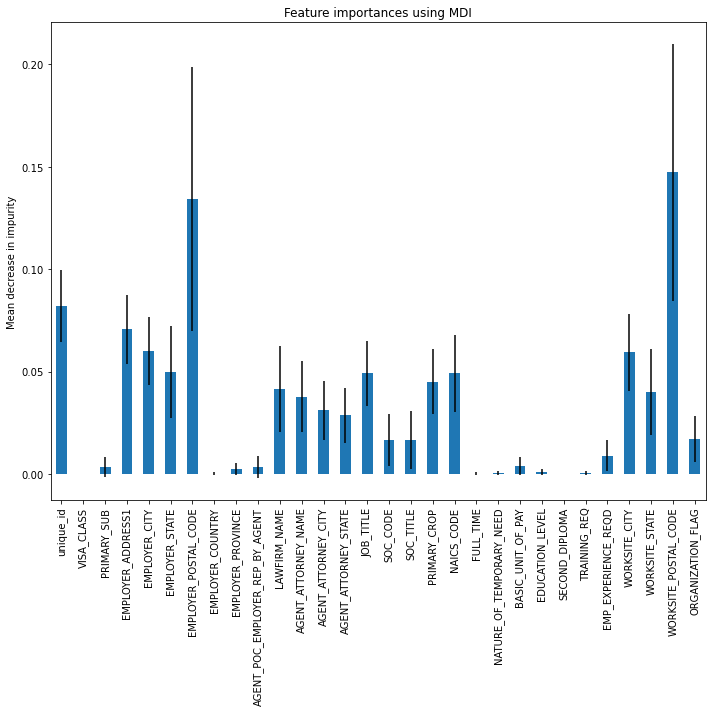

In [47]:
start_time = time.time()
importances = clf.feature_importances_
std = np.std([
    tree.feature_importances_ for tree in clf.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: "
      f"{elapsed_time:.3f} seconds")
print(importances)
forest_importances = pd.Series(importances, index=text_features_of_int)

fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(10)
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()